In [311]:
import pandas as pd
import os
import numpy as np
import cv2
import json
import glob
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score,average_precision_score,precision_score,recall_score
import tqdm
from PIL import Image
from sklearn.neighbors import NearestNeighbors

In [312]:
def contour2centroid(arr):
    length = arr.shape[0]
    sum_x = np.sum(arr[:, 0])
    sum_y = np.sum(arr[:, 1])
    return sum_x/length, sum_y/length

In [348]:
#open manual annotated image from geojson (exported qupath image as geojason because paquo installation failed)
src = r'\\fatherserverdw\Q\research\images\skin_aging\hovernet_tile\hovernet_manual_validation'
manual = os.path.join(src,'manual_annotation')
predicted = os.path.join(src,'predicted_nuclei_contour')
raw_ims = os.path.join(src,'raw_image')
raw_path = glob.glob(os.path.join(raw_ims,'*.tif'))
pd_annotations = glob.glob(os.path.join(predicted,'*.json'))
annotations = glob.glob(os.path.join(manual,'*.geojson'))
img_names = os.listdir(manual)
path = r'\\fatherserverdw\Q\research\images\skin_aging\hovernet_tile\hovernet_manual_validation\dl_mask'
# Note: these DL mask have issue with epidermal-dermal junction having pixel value above 12.
dl_masks = glob.glob(os.path.join(path,'*.tif'))

tissue_id = list(range(0,13))

In [364]:
#generate overall dataframe for csv
columns = ['mean_jaccard','mean_dice1','mean_precision','mean_recall','aji','dice2','pq','sq','dq']
scores_name = ['jaccard','dice','precision','recall']

for score in scores_name:
    for i in range(1,13):
        columns.append(score + '_id' + str(i))

for i in range(0,13):
    columns.append('tissue_composition' + str(i))

tissue_region_scores = pd.DataFrame(0.0, index=img_names,columns=columns)



In [350]:
raw_path_idx = 0

for annotation in annotations:

    with open(annotation) as f:
      features = json.load(f)["features"]
    #iterate through other stuff
    raw_img = cv2.imread(raw_path[raw_path_idx])
    dim = raw_img.shape
    image_size = (dim[0],dim[1])
    img_name = img_names[raw_path_idx]
     #open prediction
    pd_annotation = pd_annotations[raw_path_idx]


    man_coordinates = [np.squeeze(_['geometry']['coordinates']) for _ in features]
    manual_df = pd.DataFrame({'contour':man_coordinates})
    manual_df['centroid']=manual_df['contour'].apply(lambda row:contour2centroid(row))

    with open(pd_annotation) as pd_f:
      #bbox, centroid, contour
      pd_features = json.load(pd_f)["nuc"]

    #create a list of predicted contours
    pd_contours=[]
    pd_centroids = []
    for key in pd_features:
        temp = pd_features.get(key)
        pd_contours.append(np.array(temp.get('contour')))
        pd_centroids.append(np.round(temp.get('centroid'),0).astype('int'))

    predicted_df = pd.DataFrame({'contour':pd_contours,'centroid':pd_centroids})



    #get size of origianl image
    raw = glob.glob(os.path.join(raw_ims,'*.tif'))
    raw_img = cv2.imread(raw[0])
    dim = raw_img.shape
    image_size = (dim[0],dim[1])

    #create a list of manual centroids, and a list of predicted centroids
    manual_centroid= np.array(manual_df['centroid'].values.tolist())
    predicted_centroid= np.array(predicted_df['centroid'].values.tolist())
    nbrs = NearestNeighbors(n_neighbors=1, metric='euclidean').fit(predicted_centroid) #build model
    distances, indices = nbrs.kneighbors(manual_centroid) #apply model
    indices=np.squeeze(indices)



    #false positive indexes
    # (but we also need to add the ones with low iou,we don't know if it's a false positive or false negative
    unpaired_predicted_idx_1 = [_ for _ in np.array(predicted_df.index) if _ not in np.unique(indices)]

    predicted_df2 = predicted_df.iloc[indices]
    linked_df = manual_df
    linked_df['pred_contour'] =predicted_df2.contour.reset_index(drop=True)
    linked_df['pred_centroid'] =predicted_df2.centroid.reset_index(drop=True)
    linked_df['pred_idx'] = predicted_df2.index



    scores=[]
    paired_pred_idx = []
    #label is the pixel value (color) from [1,384]
    for index, row in linked_df.iterrows():
        groundtruth_mask = np.zeros(image_size)
        predicted_mask = np.zeros(image_size)
        groundtruth_mask = cv2.fillPoly(groundtruth_mask, pts=[np.array(row['contour']).astype(np.int32)],  color=1)
        predicted_mask = cv2.fillPoly(predicted_mask, pts=[np.array(row['pred_contour']).astype(np.int32)],  color=1)
        score = jaccard_score(groundtruth_mask,predicted_mask, average="micro")
        scores.append(score)

        #ashley added,if doesn't work, delete
        if(score >= 0.5):
            #add to paired nuclei idx
            paired_pred_idx.append(row['pred_idx'])

    unpaired_predicted_idx_2 =  set(indices) - set(paired_pred_idx)

    unpaired_pred_contour = []
    #iterate through idx list1
    for idx in unpaired_predicted_idx_1:
        unpaired_pred_contour.append(predicted_df.iloc[idx].contour)

    for idx in unpaired_predicted_idx_2:
        unpaired_pred_contour.append(predicted_df.iloc[idx].contour)

    linked_df['jaccard_score']=scores

    #test, compute metrics for paried nucleus
    #add the score for each pair tp dataframe

    #----metrics for each nuclei-----
    #dice_1
    dice1 = []
    # prediction score
    precision = []
    recall=[]

    #average precision score is for the whole image

    #pq
    paired_true=0
    unpaired_true=0
    paired_iou = []
    #threshold for iou
    match_iou = 0.5

    #aji
    paired_inter= []
    paired_union = []
    #dice2
    paired_total=[]
    #masks
    unpaired_true_masks = []
    paired_pred_masks = []
    unpaired_pred_masks =[]


    for index, row in linked_df.iterrows():
        groundtruth_mask = np.zeros(image_size)
        predicted_mask = np.zeros(image_size)
        groundtruth_mask = cv2.fillPoly(groundtruth_mask, pts=[np.array(row['contour']).astype(np.int32)],  color=1)
        predicted_mask = cv2.fillPoly(predicted_mask, pts=[np.array(row['pred_contour']).astype(np.int32)],  color=1)

        inter1 = groundtruth_mask * predicted_mask
        denom = groundtruth_mask + predicted_mask
        dice = 2.0 * np.sum(inter1) / np.sum((denom+1.0e-6))
        dice1.append(dice)

        p = precision_score(groundtruth_mask,predicted_mask, average="micro")
        precision.append(p)

        r = recall_score(groundtruth_mask,predicted_mask, average="micro")
        recall.append(r)

        iou = jaccard_score(groundtruth_mask,predicted_mask, average="micro")
        if(iou >= 0.5):#different thresholds give different results
            total = ( groundtruth_mask + predicted_mask).sum()
            inter = ( groundtruth_mask * predicted_mask).sum()
            paired_inter.append(inter)
            paired_union.append(total-inter)
            paired_total.append(total)
            paired_pred_masks.append(predicted_mask)
            paired_true += 1
            paired_iou.append(iou)

        else:
            unpaired_true_masks.append(groundtruth_mask)
            unpaired_true += 1

    #add scores to dataframe
    linked_df['dice1']=dice1
    linked_df['precision']=precision
    linked_df['recall'] = recall

    #Panoptic Quality (not finished, this is for the whole image)
    tp = paired_true #it's length
    fp = len(unpaired_pred_contour)
    fn = unpaired_true

    # get the F1-score i.e DQ
    dq = tp / (tp + 0.5 * fp + 0.5 * fn)

    # get the SQ, no paired has 0 iou so not impact
    sq = sum(paired_iou) / (tp + 1.0e-6)

    #Panoptic Quality and aji is for the whole image
    pq = dq * sq


    #calcualte aji score for overall image
    overall_inter = sum(paired_inter)
    overall_union = sum(paired_union)
    overall_total = sum(paired_total)

    #calcuate dice2 here, because it doesn't include the unpaired nucleus
    dice2  = 2 * overall_inter / overall_total

    #add unpaired true to overall union
    for up_true in unpaired_true_masks:
        overall_union += ( up_true * 1).sum() #?does this work??

    #add unpaired predicted to overall union
    for up_pred in unpaired_pred_contour:
        predicted_mask = np.zeros(image_size)
        predicted_mask = cv2.fillPoly(predicted_mask, pts=[np.array(up_pred).astype(np.int32)],  color=1)
        overall_union+= (predicted_mask * 1).sum()

    #aji score
    aji_score = overall_inter / overall_union

    #overall mean
    mean_dice1 = linked_df["dice1"].mean()
    mean_jaccard = linked_df["jaccard_score"].mean()
    mean_pre = linked_df["precision"].mean()
    mean_recall = linked_df["recall"].mean()

    #add score to csv
    tissue_region_scores.loc[img_name] = pd.Series({'mean_jaccard':mean_jaccard,'mean_dice1':mean_dice1,'mean_precision':mean_pre,'mean_recall':mean_recall,'aji':aji_score,'dice2':dice2,'pq':pq,'sq':sq,'dq':dq})

    linked_df.drop('pred_idx', axis=1, inplace=True)
    linked_df.to_pickle("./{}.pkl".format(img_name))



    mask = dl_masks[raw_path_idx]
    mask_img = Image.open(mask)
    m_arr = np.array(mask_img)
    m_arr[m_arr>12]=0
    m_arr[m_arr==1]=2
    m_arr[m_arr==12]=10
    hist,bin_edges = np.histogram(mask_img,bins=np.unique(m_arr))

    #assign tissue id to each nuclei
    ids = []
    for idx, row in linked_df.iterrows():
        cent = tuple(np.round(row['centroid']).astype("int32"))
        id = m_arr[cent]
        ids.append(id)

    linked_df['tissue_id']=ids



    #this is used to calculate each individual tissue region's mean scores
    tissue_region_count = np.zeros(shape=(len(tissue_id),4))
    temp_tissue_region_scores = pd.DataFrame(0.0, index=tissue_id, columns=scores_name)

    #iterate through dataframe again to calculate tissue region's mean scores
    for idx,row in linked_df.iterrows():
        id = row['tissue_id']
        temp_tissue_region_scores.iloc[id]['jaccard'] += row['jaccard_score']
        if(row['jaccard_score'] != 0):
            tissue_region_count[id][0] += 1
        temp_tissue_region_scores.iloc[id]['dice'] += row['dice1']
        if(row['dice1'] != 0):
            tissue_region_count[id][1] += 1
        temp_tissue_region_scores.iloc[id]['precision'] += row['precision']
        if(row['precision'] != 0):
            tissue_region_count[id][2] += 1
        temp_tissue_region_scores.iloc[id]['recall'] += row['recall']
        if(row['recall'] != 0):
            tissue_region_count[id][3] += 1

    for idx, row in temp_tissue_region_scores.iterrows():

        if(tissue_region_count[idx][0] != 0):
            row['jaccard']  = row['jaccard'] / tissue_region_count[idx][0]
        if(tissue_region_count[idx][1] != 0):
            row['dice']  = row['dice'] / tissue_region_count[idx][1]
        if(tissue_region_count[idx][2] != 0):
            row['precision']  = row['precision'] / tissue_region_count[idx][2]
        if(tissue_region_count[idx][3] != 0):
            row['recall']  = row['recall'] / tissue_region_count[idx][3]
    #loop through the tissue_score_df the stupid way
    for score in scores_name:
        for i in range(1,13): #order is jaccard,dice,precision,recall
            col_name = score + '_id' + str(i)
            tissue_region_scores.iloc[raw_path_idx][col_name] = temp_tissue_region_scores.iloc[i][score]

     #increment
    raw_path_idx +=1





In [353]:
tissue_region_scores

,mean_jaccard,mean_dice1,mean_precision,mean_recall,aji,dice2,pq,sq,dq,jaccard_id1,...,recall_id3,recall_id4,recall_id5,recall_id6,recall_id7,recall_id8,recall_id9,recall_id10,recall_id11,recall_id12
imID008_sec1_tile11.geojson,0.619867,0.712645,0.809288,0.659163,0.605057,0.855908,0.624584,0.746031,0.837209,0.727589,...,0.000000,0.000000,0.679389,0.000000,0.736801,0.248227,0.694283,0.743659,0.000000,0.792110
imID008_sec1_tile12.geojson,0.599001,0.705896,0.847679,0.624160,0.527262,0.827546,0.558808,0.699866,0.798450,0.000000,...,0.000000,0.000000,0.751624,0.756697,0.787446,0.882401,0.632685,0.705900,0.000000,0.000000
imID008_sec1_tile68.geojson,0.674853,0.751708,0.794418,0.729442,0.697598,0.889533,0.686881,0.792366,0.866873,0.000000,...,0.845964,0.819019,0.834237,0.820621,0.847963,0.854625,0.902526,0.818474,0.867159,0.000000
imID008_sec1_tile74.geojson,0.590726,0.669767,0.753517,0.619792,0.625123,0.875086,0.616992,0.766457,0.804992,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.750685,0.735208,0.693519,0.779730,0.000000,0.899408
imID379_sec1_tile33.geojson,0.772015,0.851519,0.913930,0.807336,0.732304,0.895436,0.720163,0.804182,0.895522,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.842240,0.000000,0.000000,0.843086,0.000000,0.781883
imID379_sec1_tile92.geojson,0.659137,0.749382,0.809843,0.714566,0.652287,0.863803,0.644157,0.745866,0.863636,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.809588,0.000000,0.771574


In [332]:
tissue_region_scores.to_csv('./overall.csv')

In [ ]:
#take stuff out and examine individual dataframes
#score of 1 doesn't look right

#image1 precision id8


In [ ]:
raw_path_idx = 0
annotation = annotations[0]
with open(annotation) as f:
  features = json.load(f)["features"]
#iterate through other stuff
raw_img = cv2.imread(raw_path[raw_path_idx])
dim = raw_img.shape
image_size = (dim[0],dim[1])
img_name = img_names[raw_path_idx]
 #open prediction
pd_annotation = pd_annotations[raw_path_idx]


man_coordinates = [np.squeeze(_['geometry']['coordinates']) for _ in features]
manual_df = pd.DataFrame({'contour':man_coordinates})
manual_df['centroid']=manual_df['contour'].apply(lambda row:contour2centroid(row))

with open(pd_annotation) as pd_f:
  #bbox, centroid, contour
  pd_features = json.load(pd_f)["nuc"]

#create a list of predicted contours
pd_contours=[]
pd_centroids = []
for key in pd_features:
    temp = pd_features.get(key)
    pd_contours.append(np.array(temp.get('contour')))
    pd_centroids.append(np.round(temp.get('centroid'),0).astype('int'))

predicted_df = pd.DataFrame({'contour':pd_contours,'centroid':pd_centroids})



#get size of origianl image
raw = glob.glob(os.path.join(raw_ims,'*.tif'))
raw_img = cv2.imread(raw[0])
dim = raw_img.shape
image_size = (dim[0],dim[1])

#create a list of manual centroids, and a list of predicted centroids
manual_centroid= np.array(manual_df['centroid'].values.tolist())
predicted_centroid= np.array(predicted_df['centroid'].values.tolist())
nbrs = NearestNeighbors(n_neighbors=1, metric='euclidean').fit(predicted_centroid) #build model
distances, indices = nbrs.kneighbors(manual_centroid) #apply model
indices=np.squeeze(indices)



#false positive indexes
# (but we also need to add the ones with low iou,we don't know if it's a false positive or false negative
unpaired_predicted_idx_1 = [_ for _ in np.array(predicted_df.index) if _ not in np.unique(indices)]

predicted_df2 = predicted_df.iloc[indices]
linked_df = manual_df
linked_df['pred_contour'] =predicted_df2.contour.reset_index(drop=True)
linked_df['pred_centroid'] =predicted_df2.centroid.reset_index(drop=True)
linked_df['pred_idx'] = predicted_df2.index



scores=[]
paired_pred_idx = []
#label is the pixel value (color) from [1,384]
for index, row in linked_df.iterrows():
    groundtruth_mask = np.zeros(image_size)
    predicted_mask = np.zeros(image_size)
    groundtruth_mask = cv2.fillPoly(groundtruth_mask, pts=[np.array(row['contour']).astype(np.int32)],  color=1)
    predicted_mask = cv2.fillPoly(predicted_mask, pts=[np.array(row['pred_contour']).astype(np.int32)],  color=1)
    score = jaccard_score(groundtruth_mask,predicted_mask, average="micro")
    scores.append(score)

    #ashley added,if doesn't work, delete
    if(score >= 0.5):
        #add to paired nuclei idx
        paired_pred_idx.append(row['pred_idx'])

unpaired_predicted_idx_2 =  set(indices) - set(paired_pred_idx)

unpaired_pred_contour = []
#iterate through idx list1
for idx in unpaired_predicted_idx_1:
    unpaired_pred_contour.append(predicted_df.iloc[idx].contour)

for idx in unpaired_predicted_idx_2:
    unpaired_pred_contour.append(predicted_df.iloc[idx].contour)

linked_df['jaccard_score']=scores

#test, compute metrics for paried nucleus
#add the score for each pair tp dataframe

#----metrics for each nuclei-----
#dice_1
dice1 = []
# prediction score
precision = []
recall=[]

#average precision score is for the whole image

#pq
paired_true=0
unpaired_true=0
paired_iou = []
#threshold for iou
match_iou = 0.5

#aji
paired_inter= []
paired_union = []
#dice2
paired_total=[]
#masks
unpaired_true_masks = []
paired_pred_masks = []
unpaired_pred_masks =[]


for index, row in linked_df.iterrows():
    groundtruth_mask = np.zeros(image_size)
    predicted_mask = np.zeros(image_size)
    groundtruth_mask = cv2.fillPoly(groundtruth_mask, pts=[np.array(row['contour']).astype(np.int32)],  color=1)
    predicted_mask = cv2.fillPoly(predicted_mask, pts=[np.array(row['pred_contour']).astype(np.int32)],  color=1)

    inter1 = groundtruth_mask * predicted_mask
    denom = groundtruth_mask + predicted_mask
    dice = 2.0 * np.sum(inter1) / np.sum((denom+1.0e-6))
    dice1.append(dice)

    p = precision_score(groundtruth_mask,predicted_mask, average="micro")
    precision.append(p)

    r = recall_score(groundtruth_mask,predicted_mask, average="micro")
    recall.append(r)

    iou = jaccard_score(groundtruth_mask,predicted_mask, average="micro")
    if(iou >= 0.5):#different thresholds give different results
        total = ( groundtruth_mask + predicted_mask).sum()
        inter = ( groundtruth_mask * predicted_mask).sum()
        paired_inter.append(inter)
        paired_union.append(total-inter)
        paired_total.append(total)
        paired_pred_masks.append(predicted_mask)
        paired_true += 1
        paired_iou.append(iou)

    else:
        unpaired_true_masks.append(groundtruth_mask)
        unpaired_true += 1

#add scores to dataframe
linked_df['dice1']=dice1
linked_df['precision']=precision
linked_df['recall'] = recall

#Panoptic Quality (not finished, this is for the whole image)
tp = paired_true #it's length
fp = len(unpaired_pred_contour)
fn = unpaired_true

# get the F1-score i.e DQ
dq = tp / (tp + 0.5 * fp + 0.5 * fn)

# get the SQ, no paired has 0 iou so not impact
sq = sum(paired_iou) / (tp + 1.0e-6)

#Panoptic Quality and aji is for the whole image
pq = dq * sq


#calcualte aji score for overall image
overall_inter = sum(paired_inter)
overall_union = sum(paired_union)
overall_total = sum(paired_total)

#calcuate dice2 here, because it doesn't include the unpaired nucleus
dice2  = 2 * overall_inter / overall_total

#add unpaired true to overall union
for up_true in unpaired_true_masks:
    overall_union += ( up_true * 1).sum() #?does this work??

#add unpaired predicted to overall union
for up_pred in unpaired_pred_contour:
    predicted_mask = np.zeros(image_size)
    predicted_mask = cv2.fillPoly(predicted_mask, pts=[np.array(up_pred).astype(np.int32)],  color=1)
    overall_union+= (predicted_mask * 1).sum()

#aji score
aji_score = overall_inter / overall_union

#overall mean
mean_dice1 = linked_df["dice1"].mean()
mean_jaccard = linked_df["jaccard_score"].mean()
mean_pre = linked_df["precision"].mean()
mean_recall = linked_df["recall"].mean()

#add score to csv


linked_df.drop('pred_idx', axis=1, inplace=True)
linked_df.to_pickle("./{}.pkl".format(img_name))



mask = dl_masks[raw_path_idx]
mask_img = Image.open(mask)
m_arr = np.array(mask_img)
m_arr[m_arr>12]=0
hist,bin_edges = np.histogram(mask_img,bins=np.unique(m_arr))

In [366]:
np.histogram(mask_img,bins=np.unique(m_arr))

(array([  6774,  88562, 227424,    372,    305,   7173,    845,   6889,
          5181,  16980, 401568, 237600], dtype=int64),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12], dtype=uint8))

In [376]:
np.sum(m_arr==11)
comp = hist/np.sum(hist)

682

In [ ]:

#assign tissue id to each nuclei
ids = []
for idx, row in linked_df.iterrows():
    cent = tuple(np.round(row['centroid']).astype("int32"))
    id = m_arr[cent]
    ids.append(id)

linked_df['tissue_id']=ids



#this is used to calculate each individual tissue region's mean scores
tissue_region_count = np.zeros(shape=(len(tissue_id),4))
temp_tissue_region_scores = pd.DataFrame(0.0, index=tissue_id, columns=scores_name)

#iterate through dataframe again to calculate tissue region's mean scores
for idx,row in linked_df.iterrows():
    id = row['tissue_id']
    temp_tissue_region_scores.iloc[id]['jaccard'] += row['jaccard_score']
    if(row['jaccard_score'] != 0):
        tissue_region_count[id][0] += 1
    temp_tissue_region_scores.iloc[id]['dice'] += row['dice1']
    if(row['dice1'] != 0):
        tissue_region_count[id][1] += 1
    temp_tissue_region_scores.iloc[id]['precision'] += row['precision']
    if(row['precision'] != 0):
        tissue_region_count[id][2] += 1
    temp_tissue_region_scores.iloc[id]['recall'] += row['recall']
    if(row['recall'] != 0):
        tissue_region_count[id][3] += 1

for idx, row in temp_tissue_region_scores.iterrows():

    if(tissue_region_count[idx][0] != 0):
        row['jaccard']  = row['jaccard'] / tissue_region_count[idx][0]
    if(tissue_region_count[idx][1] != 0):
        row['dice']  = row['dice'] / tissue_region_count[idx][1]
    if(tissue_region_count[idx][2] != 0):
        row['precision']  = row['precision'] / tissue_region_count[idx][2]
    if(tissue_region_count[idx][3] != 0):
        row['recall']  = row['recall'] / tissue_region_count[idx][3]




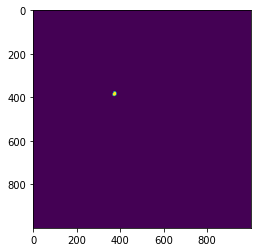

In [363]:
plt.imshow(groundtruth_mask)

In [359]:
temp_tissue_region_scores

,jaccard,dice,precision,recall
0,0.473029,0.608191,0.679817,0.681377
1,0.727589,0.828952,0.898037,0.805864
2,0.720771,0.829018,0.951502,0.756199
3,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000
5,0.679389,0.805430,1.000000,0.679389
6,0.000000,0.000000,0.000000,0.000000
7,0.717565,0.822570,0.974602,0.736801
8,0.248227,0.395480,1.000000,0.248227
9,0.692308,0.810935,0.997114,0.694283


In [360]:
linked_df

,contour,centroid,pred_contour,pred_centroid,jaccard_score,dice1,precision,recall,tissue_id
0,"[[368, 427], [368, 428], [367, 428], [366, 429...","(369.93939393939394, 438.969696969697)","[[369, 428], [367, 430], [367, 431], [366, 432...","[370, 439]",0.776923,0.872570,1.000000,0.776923,2
1,"[[242, 339], [241, 340], [239, 340], [238, 341...","(242.16666666666666, 346.2142857142857)","[[242, 338], [241, 339], [239, 339], [238, 340...","[242, 346]",0.890152,0.940000,0.955285,0.928854,1
2,"[[168, 364], [167, 365], [166, 365], [166, 366...","(172.02564102564102, 371.64102564102564)","[[172, 363], [171, 364], [169, 364], [168, 365...","[173, 372]",0.854305,0.919786,0.966292,0.880546,12
3,"[[322, 384], [321, 385], [320, 385], [319, 386...","(325.8695652173913, 392.4130434782609)","[[321, 384], [320, 385], [319, 385], [316, 388...","[325, 392]",0.815873,0.897033,0.955390,0.848185,2
4,"[[387, 334], [387, 335], [386, 335], [386, 336...","(390.0408163265306, 342.7959183673469)","[[391, 334], [390, 335], [388, 335], [387, 336...","[390, 343]",0.821429,0.900489,0.992806,0.826347,2
...,...,...,...,...,...,...,...,...,...
379,"[[230.0, 311.0], [230.0, 313.0], [233.0, 313.0...","(248.45238095238096, 313.3095238095238)","[[242, 338], [241, 339], [239, 339], [238, 340...","[242, 346]",0.000000,0.000000,0.000000,0.000000,1
380,"[[370, 314], [370, 315], [369, 315], [369, 317...","(390.7014925373134, 322.2089552238806)","[[360, 314], [359, 315], [357, 315], [356, 316...","[377, 320]",0.541069,0.701606,0.585331,0.877378,2
381,"[[959.0, 403.0], [959.0, 404.0], [957.0, 404.0...","(961.75, 413.4935897435897)","[[957, 405], [956, 406], [954, 406], [952, 408...","[960, 413]",0.730627,0.843450,0.987531,0.737430,10
382,"[[543, 354], [543, 355], [542, 355], [542, 356...","(547.936170212766, 360.7659574468085)","[[545, 354], [544, 355], [542, 355], [540, 357...","[549, 361]",0.890977,0.940476,0.987500,0.901141,10


In [ ]:
#delete eveything after this line

In [ ]:
#make sure that the image names and the raw image are in the same order as the annotations
#NOTE!!: need to make sure every manual, predicted, mask, and raw images are in the same order
raw_path_idx = 0

for annotation in annotations:
    with open(annotation) as f:
      features = json.load(f)["features"]
    #iterate through other stuff
    raw_img = cv2.imread(raw_path[raw_path_idx])
    dim = raw_img.shape
    image_size = (dim[0],dim[1])
    img_name = img_names[raw_path_idx]
     #open prediction
    pd_annotation = pd_annotations[raw_path_idx]


    man_coordinates = [np.squeeze(_['geometry']['coordinates']) for _ in features]
    manual_df = pd.DataFrame({'contour':man_coordinates})
    manual_df['centroid']=manual_df['contour'].apply(lambda row:contour2centroid(row))

    with open(pd_annotation) as pd_f:
      #bbox, centroid, contour
      pd_features = json.load(pd_f)["nuc"]

    #create a list of predicted contours
    pd_contours=[]
    pd_centroids = []
    for key in pd_features:
        temp = pd_features.get(key)
        pd_contours.append(np.array(temp.get('contour')))
        pd_centroids.append(np.round(temp.get('centroid'),0).astype('int'))

    predicted_df = pd.DataFrame({'contour':pd_contours,'centroid':pd_centroids})



    #get size of origianl image
    raw = glob.glob(os.path.join(raw_ims,'*.tif'))
    raw_img = cv2.imread(raw[0])
    dim = raw_img.shape
    image_size = (dim[0],dim[1])

    #create a list of manual centroids, and a list of predicted centroids
    manual_centroid= np.array(manual_df['centroid'].values.tolist())
    predicted_centroid= np.array(predicted_df['centroid'].values.tolist())
    nbrs = NearestNeighbors(n_neighbors=1, metric='euclidean').fit(predicted_centroid) #build model
    distances, indices = nbrs.kneighbors(manual_centroid) #apply model
    indices=np.squeeze(indices)



    #false positive indexes
    # (but we also need to add the ones with low iou,we don't know if it's a false positive or false negative
    unpaired_predicted_idx_1 = [_ for _ in np.array(predicted_df.index) if _ not in np.unique(indices)]

    predicted_df2 = predicted_df.iloc[indices]
    linked_df = manual_df
    linked_df['pred_contour'] =predicted_df2.contour.reset_index(drop=True)
    linked_df['pred_centroid'] =predicted_df2.centroid.reset_index(drop=True)
    linked_df['pred_idx'] = predicted_df2.index



    scores=[]
    paired_pred_idx = []
    #label is the pixel value (color) from [1,384]
    for index, row in linked_df.iterrows():
        groundtruth_mask = np.zeros(image_size)
        predicted_mask = np.zeros(image_size)
        groundtruth_mask = cv2.fillPoly(groundtruth_mask, pts=[np.array(row['contour']).astype(np.int32)],  color=1)
        predicted_mask = cv2.fillPoly(predicted_mask, pts=[np.array(row['pred_contour']).astype(np.int32)],  color=1)
        score = jaccard_score(groundtruth_mask,predicted_mask, average="micro")
        scores.append(score)

        #ashley added,if doesn't work, delete
        if(score >= 0.5):
            #add to paired nuclei idx
            paired_pred_idx.append(row['pred_idx'])

    unpaired_predicted_idx_2 =  set(indices) - set(paired_pred_idx)

    unpaired_pred_contour = []
    #iterate through idx list1
    for idx in unpaired_predicted_idx_1:
        unpaired_pred_contour.append(predicted_df.iloc[idx].contour)

    for idx in unpaired_predicted_idx_2:
        unpaired_pred_contour.append(predicted_df.iloc[idx].contour)

    linked_df['jaccard_score']=scores

#test, compute metrics for paried nucleus
    #add the score for each pair tp dataframe

    #----metrics for each nuclei-----
    #dice_1
    dice1 = []
    # prediction score
    precision = []
    recall=[]

    #average precision score is for the whole image

    #pq
    paired_true=0
    unpaired_true=0
    paired_iou = []
    #threshold for iou
    match_iou = 0.5

    #aji
    paired_inter= []
    paired_union = []
    #dice2
    paired_total=[]
    #masks
    unpaired_true_masks = []
    paired_pred_masks = []
    unpaired_pred_masks =[]


    for index, row in linked_df.iterrows():
        groundtruth_mask = np.zeros(image_size)
        predicted_mask = np.zeros(image_size)
        groundtruth_mask = cv2.fillPoly(groundtruth_mask, pts=[np.array(row['contour']).astype(np.int32)],  color=1)
        predicted_mask = cv2.fillPoly(predicted_mask, pts=[np.array(row['pred_contour']).astype(np.int32)],  color=1)

        inter1 = groundtruth_mask * predicted_mask
        denom = groundtruth_mask + predicted_mask
        dice = 2.0 * np.sum(inter1) / np.sum((denom+1.0e-6))
        dice1.append(dice)

        p = precision_score(groundtruth_mask,predicted_mask, average="micro")
        precision.append(p)

        r = recall_score(groundtruth_mask,predicted_mask, average="micro")
        recall.append(r)

        iou = jaccard_score(groundtruth_mask,predicted_mask, average="micro")
        if(iou >= 0.5):#different thresholds give different results
            total = ( groundtruth_mask + predicted_mask).sum()
            inter = ( groundtruth_mask * predicted_mask).sum()
            paired_inter.append(inter)
            paired_union.append(total-inter)
            paired_total.append(total)
            paired_pred_masks.append(predicted_mask)
            paired_true += 1
            paired_iou.append(iou)

        else:
            unpaired_true_masks.append(groundtruth_mask)
            unpaired_true += 1

    #add scores to dataframe
    linked_df['dice1']=dice1
    linked_df['precision']=precision
    linked_df['recall'] = recall

    #Panoptic Quality (not finished, this is for the whole image)
    tp = paired_true #it's length
    fp = len(unpaired_pred_contour)
    fn = unpaired_true

    # get the F1-score i.e DQ
    dq = tp / (tp + 0.5 * fp + 0.5 * fn)

    # get the SQ, no paired has 0 iou so not impact
    sq = sum(paired_iou) / (tp + 1.0e-6)

    #Panoptic Quality and aji is for the whole image
    pq = dq * sq


    #calcualte aji score for overall image
    overall_inter = sum(paired_inter)
    overall_union = sum(paired_union)
    overall_total = sum(paired_total)

    #calcuate dice2 here, because it doesn't include the unpaired nucleus
    dice2  = 2 * overall_inter / overall_total

    #add unpaired true to overall union
    for up_true in unpaired_true_masks:
        overall_union += ( up_true * 1).sum() #?does this work??

    #add unpaired predicted to overall union
    for up_pred in unpaired_pred_contour:
        predicted_mask = np.zeros(image_size)
        predicted_mask = cv2.fillPoly(predicted_mask, pts=[np.array(up_pred).astype(np.int32)],  color=1)
        overall_union+= (predicted_mask * 1).sum()

    #aji score
    aji_score = overall_inter / overall_union

    #overall mean
    mean_dice1 = linked_df["dice1"].mean()
    mean_jaccard = linked_df["jaccard_score"].mean()
    mean_pre = linked_df["precision"].mean()
    mean_recall = linked_df["recall"].mean()

    #add score to csv
    tissue_region_scores.loc[img_name] = pd.Series({'mean_jaccard':mean_jaccard,'mean_dice1':mean_dice1,'mean_precision':mean_pre,'mean_recall':mean_recall,'aji':aji_score,'dice2':dice2,'pq':pq,'sq':sq,'dq':dq})

    linked_df.drop('pred_idx', axis=1, inplace=True)
    linked_df.to_pickle("./{}.pkl".format(img_name))

    mask = dl_masks[raw_path_idx]
    mask_img = Image.open(mask)
    m_arr = np.array(mask_img)
    m_arr[m_arr>12]=0
    hist,bin_edges = np.histogram(mask_img,bins=np.unique(m_arr))



    #assign tissue id to each nuclei
    ids = []
    for idx, row in linked_df.iterrows():
        cent = tuple(np.round(row['centroid']).astype("int32"))
        id = m_arr[cent]
        ids.append(id)

    linked_df['tissue_id']=ids



    #this is used to calculate each individual tissue region's mean scores
    tissue_region_count = np.zeros(shape=(len(np.unique(m_arr)),4))
    temp_tissue_region_scores = pd.DataFrame(0, index=np.unique(m_arr), columns={'jaccard','dice','precision','recall'})


    #iterate through dataframe again to calculate tissue region's mean scores
    for idx,row in linked_df.iterrows():
        id = row['tissue_id']
        temp_tissue_region_scores.iloc[id]['jaccard'] += row['jaccard_score']
        if(row['jaccard_score'] != 0):
            tissue_region_count[id][0] += 1
        temp_tissue_region_scores.iloc[id]['dice'] += row['dice1']
        if(row['dice1'] != 0):
            tissue_region_count[id][1] += 1
        temp_tissue_region_scores.iloc[id]['precision'] += row['precision']
        if(row['precision'] != 0):
            tissue_region_count[id][2] += 1
        temp_tissue_region_scores.iloc[id]['recall'] += row['recall']
        if(row['recall'] != 0):
            tissue_region_count[id][3] += 1

         #increment
        raw_path_idx +=1

In [31]:
#https://arxiv.org/pdf/1812.06499.pdf
#this paper talks about aji, dice and pq scores

#https://github.com/vqdang/hover_net/blob/master/metrics/stats_utils.py
#code reference

#summary
#for individual pairs,the scores calculated are: iou, dice, precision, recall
#for whole image, scores calculated are: Panoptic Quality(pq,sq,dq), aji, dice2

In [32]:
#take a mean of each score
#output as pickle
#output overall score as csv: image name and scores,tissue composition (histagram), do this last (mean score per tissue object (give id to nuclei))
#TODO: need to iterate through all images

In [102]:

for idx,row in linked_df.iterrows():
    id = row['tissue_id']
    #tissue_region_scores.iloc[id]['jaccard'] = row['jaccard_score'] + tissue_region_scores.iloc[id]['jaccard']
    tissue_region_scores.iloc[id]['jaccard'] += row['jaccard_score']
    if(row['jaccard_score'] != 0):
        tissue_region_count[id][0] += 1
    tissue_region_scores.iloc[id]['dice'] += row['dice1']
    if(row['dice1'] != 0):
        tissue_region_count[id][1] += 1
    tissue_region_scores.iloc[id]['precision'] += row['precision']
    if(row['precision'] != 0):
        tissue_region_count[id][2] += 1
    tissue_region_scores.iloc[id]['recall'] += row['recall']
    if(row['recall'] != 0):
        tissue_region_count[id][3] += 1



In [107]:
#calculate the mean of the each reagion and output to pickle

#count order: 'jaccard','dice','precision','recall'
for idx, row in tissue_region_scores.iterrows():
    #jaccard
    if(tissue_region_count[idx][0] != 0):
        row['jaccard']  = row['jaccard'] / tissue_region_count[idx][0]
    if(tissue_region_count[idx][1] != 0):
        row['dice']  = row['dice'] / tissue_region_count[idx][1]
    if(tissue_region_count[idx][2] != 0):
        row['precision']  = row['precision'] / tissue_region_count[idx][2]
    if(tissue_region_count[idx][3] != 0):
        row['recall']  = row['recall'] / tissue_region_count[idx][3]



In [110]:
tissue_region_scores

,recall,jaccard,dice,precision
0,0.681377,0.157676,0.608191,0.679817
1,0.805864,0.022737,0.828952,0.898037
2,0.756199,0.010758,0.829018,0.951502
3,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000
5,0.679389,0.679389,0.805430,1.000000
6,0.000000,0.000000,0.000000,0.000000
7,0.736801,0.119594,0.822570,0.974602
8,0.248227,0.248227,0.395480,1.000000
9,0.694283,0.230769,0.810935,0.997114


In [ ]:
#output overall score as csv: image name and scores,tissue composition (histagram), do this last (mean score per tissue object (give id to nuclei))